# Modeling Notebook 

# ![Modeling Methods](images/presentation_assets/Modeling%20Method.png)

This notebook is meant to follow the [EDA notebook](eda.ipynb). In the previous notebook I preformed initial exploration and summary analysis of the data set being used in this project, as a well as formalizing the methods that will be used for evaluation. In this notebook I will build a convolutional neural network using the Python Keras API experimenting with various adjustments to find the best variation for this projects goals.

The prototype process will be as follows:  
- Begin with an initial [baseline model](#baseline-model)
- Experimenting with the [model architecture](#sophisticating-model-architecture)
- Experimenting with the [training protocol](#sophisticating-model-architecture)
- Testing various [regularization methods](#network-regularization)
- Testing various [optimization algorithms](#gradient-descent-optimization)

In [1]:
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

import numpy as np
import pandas as pd

# ![Data Source](images/presentation_assets/Data%20Overview.png)

## Data Preprocessing
Before modeling can begin the data must be formatted in a way that is readible to the model class object. This will follow the exact same preprocessing methods utilized in the previous [EDA notebook](eda.ipynb). Using the Keras ImageDataGenerator class ith the flow_from_directory() method, jpeg files from the subdirectory structure (according to the filepaths below) will be read into 4d arrays (batch index, image index, width, height). Images are set to grayscale so there will be only one colorchannel per image. 

In [2]:
# dependences for data loading and sifting
import os
from keras.preprocessing.image import ImageDataGenerator

In [3]:
# file paths to data directories
train_dir = "data/train/"
test_dir = "data/test/"
val_dir = "data/val/"

In [4]:
# instatiating a data degenerater for each split sample 
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)
                                   
val_datagen = ImageDataGenerator(rescale=1./255)

train_data_generator = train_datagen.flow_from_directory(
                       train_dir,
                       target_size=(150,150),
                       batch_size=16,
                       class_mode='binary',
                       color_mode='grayscale')

test_data_generator = test_datagen.flow_from_directory(
                      test_dir,
                      target_size=(150,150),
                      batch_size=16,
                      class_mode='binary',
                      color_mode='grayscale')

val_data_generator = val_datagen.flow_from_directory(
                     val_dir,
                     target_size=(150,150),
                     batch_size=16,
                     class_mode='binary',
                     color_mode='grayscale')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## Baseline Model
Beginning a convolutional neural network with the most simple architecture for the sake of efficient diagnostics and optimization.  
The architecture begins with a convolutional 2D layers, followed by a pooling layer, flattened, and then followed up with two dense layers.  
THe model is compiled using binary cross entropy to measure the loss function and accuracy foor the performance metric.  

In [5]:
# model class dependencies
from keras import layers
from keras import models
from keras import optimizers
from keras.metrics import Recall

In [6]:
base_model = models.Sequential()
base_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
base_model.add(layers.MaxPooling2D((2, 2)))
base_model.add(layers.Flatten())
base_model.add(layers.Dense(512, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [7]:
base_model_results = base_model.fit(train_data_generator, 
                              steps_per_epoch=20, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
20/20 [==============================] - 19s 929ms/step - loss: 2.8539 - acc: 0.6531 - recall: 0.7298 - val_loss: 1.3840 - val_acc: 0.6125 - val_recall: 1.0000
Epoch 2/5
20/20 [==============================] - 18s 921ms/step - loss: 0.5621 - acc: 0.7781 - recall: 0.8782 - val_loss: 0.6715 - val_acc: 0.6458 - val_recall: 0.9865
Epoch 3/5
20/20 [==============================] - 18s 902ms/step - loss: 0.4157 - acc: 0.8250 - recall: 0.9017 - val_loss: 0.4330 - val_acc: 0.7708 - val_recall: 0.9753
Epoch 4/5
20/20 [==============================] - 18s 913ms/step - loss: 0.3068 - acc: 0.8719 - recall: 0.9217 - val_loss: 0.3678 - val_acc: 0.8500 - val_recall: 0.8831
Epoch 5/5
20/20 [==============================] - 18s 902ms/step - loss: 0.2508 - acc: 0.8938 - recall: 0.9386 - val_loss: 0.4114 - val_acc: 0.8250 - val_recall: 0.7445


In [8]:
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 175232)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               89719296  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 89,720,129
Trainable params: 89,720,129
Non-trainable params: 0
_________________________________________________________________


### Evaluate base model

In [9]:
import project_toolkit as ptk

# this function shows a list of the functions available in the project toolkit module
ptk.toolkit_list()

['evaluate_model(model,data_generator)', 'viz_training_history(model_history,recall_num:None)', 'viz_class_balance_comparison(y_test,y_pred)', 'viz_confusion_matrix(confusion_matrix_array:np.array)']


In [10]:
# base_kpi is a tuple of (recall, loss)
# base_report is a sklearn classification report
# base_matrix is a confusion matrix as a 2d array
# base_labels is a tuple of (y_test, y_pred)
# other variables assigned with this function will follow these naming conventions througout the notebook <--- !!!

base_kpi, base_report, base_matrix, base_labels = ptk.evaluate_model(base_model,test_data_generator)
print(base_report)

20/20 [==============================] - 2s 107ms/step - loss: 0.4148 - acc: 0.8172 - recall: 0.7632
Done!
              precision    recall  f1-score   support

         0.0       0.70      0.91      0.79       243
         1.0       0.93      0.76      0.84       397

    accuracy                           0.82       640
   macro avg       0.82      0.83      0.81       640
weighted avg       0.84      0.82      0.82       640



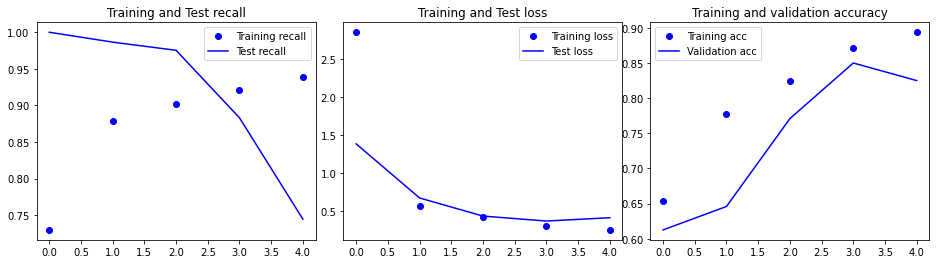

In [11]:
ptk.viz_training_history(base_model_results,recall_num="")

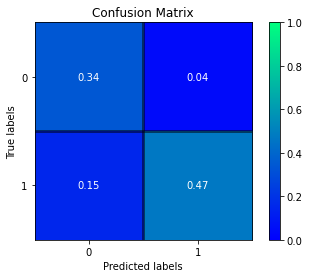

In [12]:
ptk.viz_confusion_matrix(base_matrix)

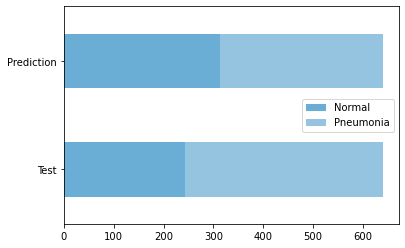

,Test,Prediction
Normal,243,314
Pneumonia,397,326


In [13]:
ptk.viz_class_balance_comparison(base_labels[0],base_labels[1])

The base model succesfully compiles and trains. F1 score is at a decent start, however recall for the target label (1.) is lower than that of its counterpart, the overall accuracy is decent however the F1 and recall for the target label needs to improve quite a bit. The training history visualization shows that the model has plenty of "room to grow". The prediction labels class balance is neary 50/50. So my opinion at this point is that the model is underfitting, or perhaps biased towards the "normal" label. 

## Sophisticating model architecture  

The next step will be to expand the model architecture. This will multiply the parameters available to the model and therefore allow it to make higher order abstractions and discover less obvious connections within the features of the data. I will sophisticate the architecture by incorporating more layers of a variety of types including convolutional layers, pooling layers, and dense layers. 

In [23]:
deep_model = models.Sequential()

deep_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
deep_model.add(layers.MaxPooling2D((2, 2)))
deep_model.add(layers.Flatten())
deep_model.add(layers.Dense(512, activation='relu'))
deep_model.add(layers.Dense(256, activation='relu'))
deep_model.add(layers.Dense(1, activation='sigmoid'))

deep_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [24]:
deep_model_results = deep_model.fit(train_data_generator, 
                              steps_per_epoch=20, 
                              epochs=5, 
                              validation_data=test_data_generator, 
                              validation_steps=15)

Epoch 1/5
20/20 [==============================] - 16s 780ms/step - loss: 0.8338 - acc: 0.7094 - recall_2: 0.9367 - val_loss: 0.5664 - val_acc: 0.8125 - val_recall_2: 0.9051
Epoch 2/5
20/20 [==============================] - 15s 730ms/step - loss: 0.5299 - acc: 0.8094 - recall_2: 0.9359 - val_loss: 0.5192 - val_acc: 0.7500 - val_recall_2: 0.9301
Epoch 3/5
20/20 [==============================] - 12s 623ms/step - loss: 0.4438 - acc: 0.8562 - recall_2: 0.9064 - val_loss: 0.6341 - val_acc: 0.7417 - val_recall_2: 0.9671
Epoch 4/5
20/20 [==============================] - 13s 626ms/step - loss: 0.2493 - acc: 0.9000 - recall_2: 0.9430 - val_loss: 1.1178 - val_acc: 0.6583 - val_recall_2: 1.0000
Epoch 5/5
20/20 [==============================] - 12s 617ms/step - loss: 0.4403 - acc: 0.8594 - recall_2: 0.9125 - val_loss: 0.7704 - val_acc: 0.7333 - val_recall_2: 1.0000


In [25]:
deep_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 36992)            

### Evaluate deeper model architecture

In [26]:
deep_kpi, deep_report, deep_matrix, deep_labels = ptk.evaluate_model(deep_model,test_data_generator)
print(deep_report)

20/20 [==============================] - 3s 139ms/step - loss: 0.8005 - acc: 0.7063 - recall_2: 0.9924
Done!
              precision    recall  f1-score   support

         0.0       0.95      0.24      0.39       244
         1.0       0.68      0.99      0.81       396

    accuracy                           0.71       640
   macro avg       0.82      0.62      0.60       640
weighted avg       0.78      0.71      0.65       640



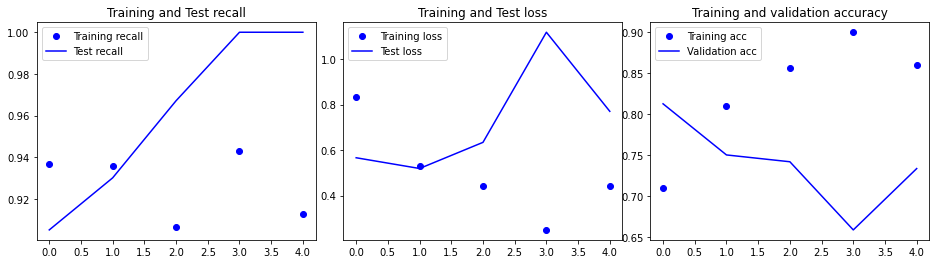

In [28]:
ptk.viz_training_history(deep_model_results,recall_num="_2")

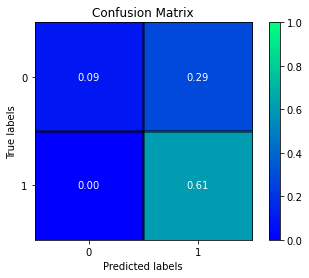

In [29]:
ptk.viz_confusion_matrix(deep_matrix)

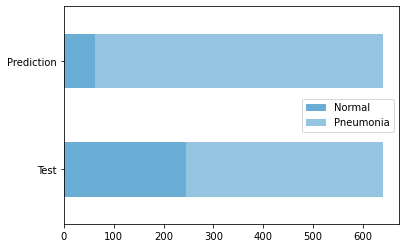

,Test,Prediction
Normal,244,62
Pneumonia,396,578


In [30]:
ptk.viz_class_balance_comparison(deep_labels[0],deep_labels[1])

## sophisticating the training protocol

The next step I will take is sophisticating the parameters of the fit function being used. My intuition is that the fit function is too simple relative to the complexity of the model architecture. 

In [ ]:
fitter_model_results = deep_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=15, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

The accuracy and loss on training data is begining to behave more as desired; however on the test data the history is still quite eratic indicating that the model is still overfitting and not able to generalize consistently. All that considered the final accuracy on the training data is the best so far so we're moving in the right direction.

In [ ]:
evaluate_model_performance(deep_model,test_data_generator)

In [ ]:
visualize_training(fitter_model_results,"_1")

## Network Regularization

### L2 regularization
I will begin regularizing the network by incorporating L2 regularization on the dense layers of the existing model architecture

In [ ]:
from keras.regularizers import l2

In [ ]:

L2_model = models.Sequential()

L2_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
L2_model.add(layers.MaxPooling2D((2, 2)))
L2_model.add(layers.Flatten())
L2_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
L2_model.add(layers.Dense(1, activation='sigmoid'))

L2_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [ ]:
# added 5 epochs from the last fit call
L2_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

In [ ]:
L2_model.summary()

L2 regularization appears to have addressed overfitting at least as far a recall is concerned. The recall is nearly perfect, however the validation loss is very high, considering this alongside that validation accuracy tends to be lower than desired, my interpretation is that the model is predicting almost all true positive cases, while also making a considrable amount of false positive predictions. This is more or less the behaviour I am looking for and is consistent with standards in the medical AI industry. The recall is well within an acceptable margin; in the interest of the end user however (i.e. the medical profesionals) I want to reduce the rate of false positives. This would reduce the amount of manual human effort required to validate diagnoses made by the model saving both time and money for both patients and service providers.  

In [ ]:
evaluate_model_performance(L2_model,test_data_generator)

In [ ]:
visualize_training(L2_model_results,"_2")

### Dropout regularization
The most common practice with dropout regularization of CNNs is including a dropout layer after each fully connected (Dense) layer. So the next step will be adding two dropout layers each with a value of 0.3, after each of the two hidden Dense layers. There will be no dropout incorporated with the output layer.

In [ ]:
dropout_model = models.Sequential()

dropout_model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,1)))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(1, activation='sigmoid'))

dropout_model.compile(
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [ ]:
dropout_model_results = dropout_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=20, 
                                        validation_data=test_data_generator, 
                                        validation_steps=25)

In [ ]:
dropout_model.summary()

Performance on validation data is still quite eradic accross training epochs, and it appears to have probably worsened recall as well as loss. I will continue with the L2 regularization and leave out any dropout layers. 

In [ ]:
evaluate_model_performance(dropout_model,test_data_generator)

In [ ]:
visualize_training(dropout_model_results,"_3")

## Gradient Descent Optimization
So far, a optimizer has not been specified in the model compiler. Below I will test 3 different optimization algorithms, and then will experiment with the learning rate of the best performing algorithm to improve it further. **I will be using a leaner fit function protocol here in the interest of time.**  
The optimizers being test are:
- Stochastic Gradient Descent (SGD)
- Adaptive Moment Estimation (Adam)
- Adaptive Delta (Adadelta)

In [ ]:
L2_model.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['acc',Recall()])

SGD_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

In [ ]:
evaluate_model_performance(L2_model,test_data_generator)

In [ ]:
visualize_training(SGD_model_results,"_4")

In [ ]:
L2_model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

Adam_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

In [ ]:
evaluate_model_performance(L2_model,test_data_generator)

In [ ]:
visualize_training(Adam_model_results,"_5")

In [ ]:
L2_model.compile(optimizer='Adadelta',
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

Adadelta_model_results = L2_model.fit(train_data_generator, 
                                        steps_per_epoch=25, 
                                        epochs=5, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

In [ ]:
evaluate_model_performance(L2_model,test_data_generator)

In [ ]:
visualize_training(Adadelta_model_results,"_6")

 I am deciding to continue investigating with the Adam optimizer because its loss function has the strongest downward trend among the three, its accuracy continually improves, and the recall although behaving oddly at this point remains within a reasonable range of 1.0 even at its lowest.  

It will be interesting to see how the learning rate affects Adams recall as well how a more robust fit function may help as well. The recall in the above plot seems to decrease over epochs, maybe more epochs are needed or maybe early stoppage would help as well. 

## Learning Rate and Early Stoppage with Adaptive Momentum Optimization

In [ ]:
adam_model = models.Sequential()

adam_model.add(layers.Conv2D(8,(3,3),activation='relu',input_shape=(150,150,1)))
adam_model.add(layers.MaxPooling2D((2, 2)))
adam_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
adam_model.add(layers.MaxPooling2D((2, 2)))
adam_model.add(layers.Flatten())
adam_model.add(layers.Dense(512, activation='relu',kernel_regularizer=l2(0.005)))
adam_model.add(layers.Dense(256, activation='relu',kernel_regularizer=l2(0.005)))
adam_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
adam_01 = optimizers.Adam(learning_rate=0.01)
adam_model.compile(optimizer=adam_01,
              loss='binary_crossentropy',
              metrics=['acc',Recall()]
              )

In [ ]:
Adam_01_model_results = adam_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=10, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

In [ ]:
adam_model.summary()

In [ ]:
evaluate_model_performance(adam_model,test_data_generator)

In [ ]:
visualize_training(Adam_01_model_results,"_7")

Improving the loss function should reduce the false positive rate, making the tool more effective to the end user. Next I will rerun the above model using early stoppage monitoring the loss function. 

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
early_stopping = [EarlyStopping(monitor='val_loss',patience=5),
                  ModelCheckpoint(filepath='data/final_model.h5',monitor='val_loss',save_best_only=True)]

In [ ]:
final_model_results = adam_model.fit(train_data_generator, 
                                        steps_per_epoch=50, 
                                        epochs=50,
                                        callbacks=early_stopping, 
                                        validation_data=test_data_generator, 
                                        validation_steps=10)

In [ ]:
evaluate_model_performance(adam_model,test_data_generator)

In [ ]:
visualize_training(final_model_results,"_7")

# Final Model QA
A final model has been decided on and saved for portability and reusability. Below I am simply loading the model and ensuring its usability as well as confirming it is consistent with its original form (in memory in this notebook).

In [ ]:
from keras.models import load_model
saved_model =  load_model('data/final_model.h5')

In [ ]:
results_train = saved_model.evaluate(train_data_generator)
print(f'Training Recall: {results_train[2]:.3} \nTraining Loss: {results_train[0]:.3} \nTraining Accuracy: {results_train[1]:.3}')

print('----------')

results_test = saved_model.evaluate(test_data_generator)
print(f'Test Recall: {results_test[2]:.3} \nTest Loss: {results_test[0]:.3} \nTest Accuracy: {results_test[1]:.3}')

print('----------')

results_val = saved_model.evaluate(val_data_generator)
print(f'Validation Recall: {results_val[2]:.3} \nValidation Loss: {results_val[0]:.3} \nValidation Accuracy: {results_val[1]:.3}')

In [ ]:
evaluate_model_performance(saved_model,val_data_generator)

## Conclusions
The final model is saved succesfully and performs within the needs of its inteneded use. It has an improvable false positive rate, however it performs well enough that I am comfortable deploying it to beta testing in the real world with select medical offices and begin developing the software through which end users will utilize the tool. While the false positive rate is extant, the false negative rate is minuscule and the true positive rate is almost perfect; this is consistent with other classification methods and AI used for medical diagnostic purposes.
